In [13]:
from utils import load_vcf_data
from mquad.mquad_utils import findKnee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [14]:
AD, DP, AF = load_vcf_data('cellsnp_masked/cellSNP.cells.vcf.gz')

loading data from cellsnp_masked/cellSNP.cells.vcf.gz...


In [15]:
#manually remove chrM_310_T_C because it is within a highly repetitive region with false positives

## also filter out cells that have 0 AD across all variants

variants = ['chrM_16147_T_C', 'chrM_9728_C_T', 'chrM_12889_G_A', 'chrM_9804_G_A', 'chrM_1227_G_A', 'chrM_9840_T_C', 
'chrM_12731_T_C', 'chrM_824_T_C', 'chrM_2285_T_C',]
sub_AD = AD.loc[variants]
sub_DP = DP.loc[variants]

from scipy.sparse import csc_matrix
#mquad_AD = csc_matrix(sub_AD.loc[:,sub_AD.sum(axis=0) > 0])
#mquad_DP = csc_matrix(sub_DP.loc[:,sub_AD.sum(axis=0) > 0])
mquad_AD = csc_matrix(sub_AD)
mquad_DP = csc_matrix(sub_DP)
mquad_AD.shape, mquad_DP.shape

((9, 3559), (9, 3559))

In [16]:
## get idx of high-quality CBs defined in mtscATAC github page

with open('CRC_filtered_barcodes.tsv') as f:
    high_qual = f.read().splitlines()

with open('cellsnp_masked/cellSNP.samples.tsv') as f:
    csp_cb = f.read().splitlines()

print(len(high_qual), len(csp_cb))

common = list(set(high_qual) & set(csp_cb))

common_idx = [csp_cb.index(i) for i in common]

1505 3559


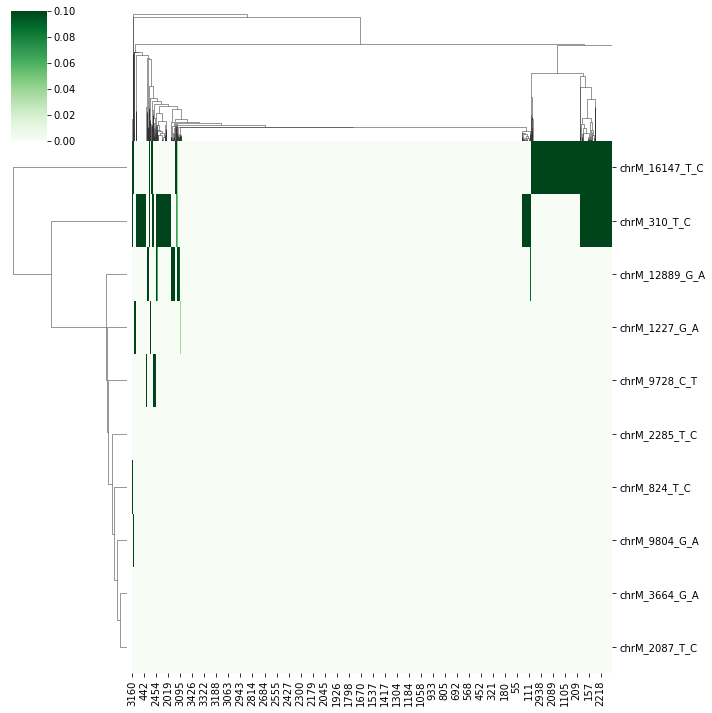

In [5]:
mquad = pd.read_csv('cellsnp_masked/mquad/BIC_params.csv')

#extract top20 pass_mincells variants and plot AF heatmap

top20 = mquad[mquad.PASS_MINCELLS == True].variant_name[0:10]

import seaborn as sns

sns.clustermap(AF.loc[top20], cmap='Greens', vmax=0.1)

In [6]:
x,y,knee_x, knee_y =findKnee(mquad.deltaBIC[mquad.deltaBIC < 1000])
knee_y

70.97326594461563

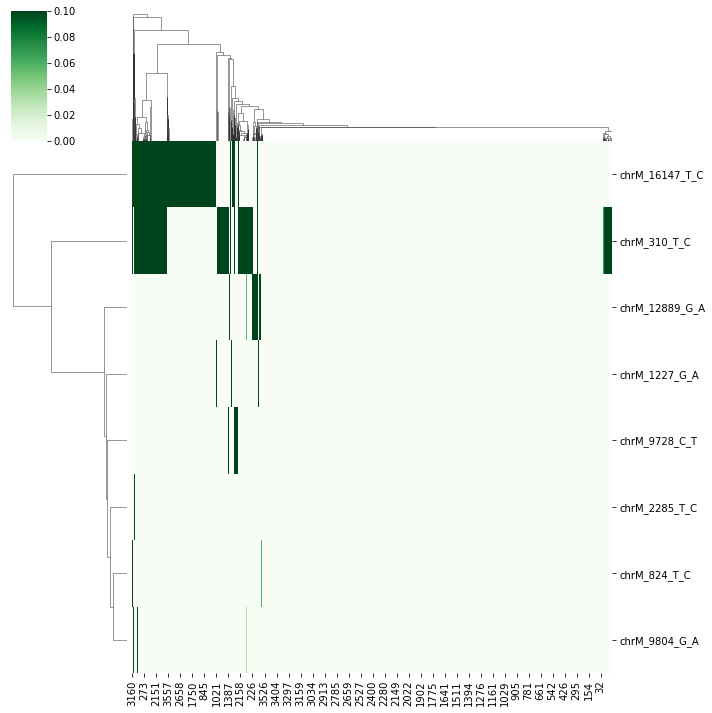

In [7]:
mquad_idx = mquad.variant_name[(mquad.deltaBIC >= knee_y) & (mquad.num_cells_minor_cpt > 3)]
sns.clustermap(AF.loc[mquad_idx], cmap='Greens', vmax=0.1)

In [15]:
variants = ['chrM_16147_T_C', 'chrM_9728_C_T', 'chrM_12889_G_A', 'chrM_9804_G_A', 'chrM_1227_G_A', 'chrM_9840_T_C', 
'chrM_6081_G_A', 'chrM_3244_G_A', 'chrM_12731_T_C', 'chrM_824_T_C', 'chrM_2285_T_C', 'chrM_16093_T_C']

In [20]:
sub_AD = AD.loc[variants]
sub_DP = DP.loc[variants]

AF_df = (sub_AD/sub_DP).fillna(0)

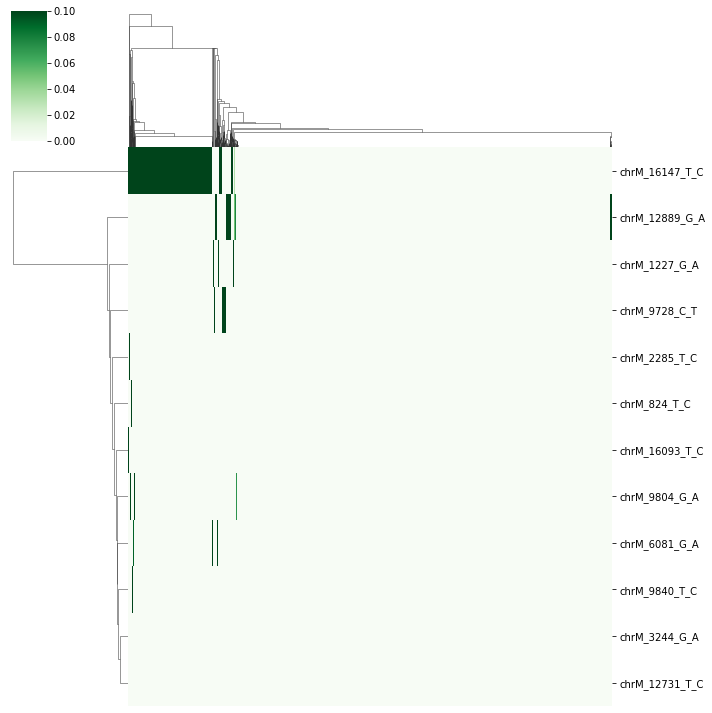

In [24]:
g = sns.clustermap(AF_df, cmap='Greens', vmax=0.1, xticklabels=False)

/home/aaronkwc/.conda/envs/pepe/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/aaronkwc/.conda/envs/pepe/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


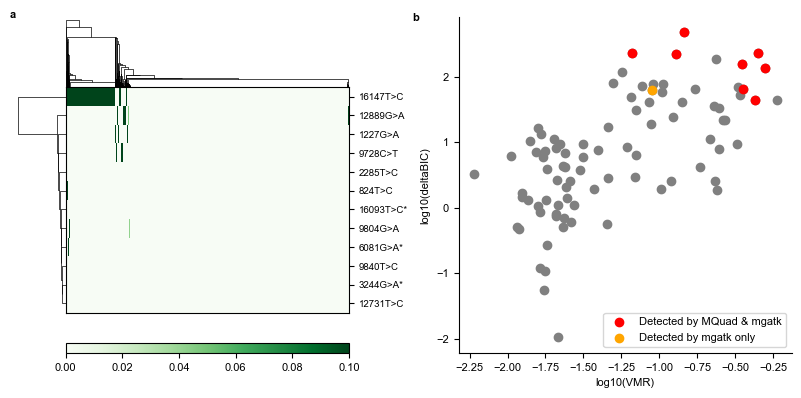

In [102]:
plt.style.use('default')
font = {'family' : 'Arial',
        'size'   : 8}
plt.rc('font', **font)
cm = 1/2.54

variants_annotated = ['16147T>C', '9728C>T', '12889G>A', '9804G>A', '1227G>A', '9840T>C', 
'6081G>A*', '3244G>A*', '12731T>C', '824T>C', '2285T>C', '16093T>C*']

from scipy.cluster.hierarchy import dendrogram

fig = plt.figure(figsize=(8,4))
ax = plt.subplot(121)
ax.text(-0.5*cm, 3.3*cm, 'a', transform = ax.transAxes, fontsize = 8, fontweight = 'bold', va='bottom', ha='left')
res = plt.imshow(AF_df.iloc[g.dendrogram_row.reordered_ind, g.dendrogram_col.reordered_ind], aspect='auto', interpolation='none', cmap='Greens', vmax=0.1)
ax.axes.xaxis.set_visible(False)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.yticks(range(len(AF_df)), [variants_annotated[i] for i in g.dendrogram_row.reordered_ind], fontsize=7)
divider = make_axes_locatable(ax)
left_ax = divider.append_axes("left", size=0.5, pad=0)
top_ax = divider.append_axes("top", size=0.7, pad=0)

top_ax.axis('off')
left_ax.axis('off')


from scipy.cluster.hierarchy import dendrogram

with plt.rc_context({'lines.linewidth': 0.5}):
    d = dendrogram(g.dendrogram_row.calculated_linkage, ax=left_ax, orientation='left', distance_sort='descending',no_labels=True, color_threshold=0, link_color_func=lambda x: 'k')


with plt.rc_context({'lines.linewidth': 0.5}):
    d = dendrogram(g.dendrogram_col.calculated_linkage, ax=top_ax, orientation='top',no_labels=True, color_threshold=0, link_color_func=lambda x: 'k')

bottom_ax = divider.append_axes("bottom", size=0.1, pad = 0.3)
plt.colorbar(res, cax = bottom_ax, orientation="horizontal", shrink=0.5)

mquad = pd.read_csv('cellsnp_masked/mquad/BIC_params.csv')

mquad[['chr', 'pos', 'ref', 'alt']] = mquad.variant_name.str.split('_', expand=True)
mquad['variant'] = mquad['pos'] + mquad['ref'] + '>' + mquad['alt']

misc_df = pd.read_csv('misc_df.csv')
matched_df = misc_df.merge(mquad)

variants = ['chrM_16147_T_C', 'chrM_9728_C_T', 'chrM_12889_G_A', 'chrM_9804_G_A', 'chrM_1227_G_A', 'chrM_9840_T_C','chrM_12731_T_C', 'chrM_824_T_C', 'chrM_2285_T_C']
mgatk_only = ['chrM_6081_G_A', 'chrM_3244_G_A', 'chrM_16093_T_C']


ax2 = plt.subplot(122)
ax2.text(-0.35*cm, 2.5*cm, 'b', transform = ax2.transAxes, fontsize = 8, fontweight = 'bold', va='bottom', ha='left')
plt.scatter(np.log10(matched_df.vmr), np.log10(matched_df.deltaBIC), color='grey')
plt.scatter(np.log10(matched_df[matched_df.variant_name.isin(variants)].vmr), np.log10(matched_df[matched_df.variant_name.isin(variants)].deltaBIC), color='r', label="Detected by MQuad & mgatk")
plt.scatter(np.log10(matched_df[matched_df.variant_name.isin(mgatk_only)].vmr), np.log10(matched_df[matched_df.variant_name.isin(mgatk_only)].deltaBIC), color='orange', label="Detected by mgatk only")
plt.legend(loc='lower right')
plt.xlabel('log10(VMR)')
plt.ylabel('log10(deltaBIC)')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.tight_layout()

plt.savefig('CRC_supp.pdf')

In [15]:
sub_AD.to_csv('mgatk_variants_AD.csv')
sub_DP.to_csv('mgatk_variants_DP.csv')

In [18]:
mquad_AD[:,common_idx]

<9x1499 sparse matrix of type '<class 'numpy.float64'>'
	with 752 stored elements in Compressed Sparse Column format>

In [25]:
from vireoSNP import BinomMixtureVB

np.random.seed(42)
_model = BinomMixtureVB(n_var=len(mquad_AD[:,common_idx].getnnz(axis=1)), n_cell=len(mquad_AD[:,common_idx].getnnz(axis=0)), n_donor=3)
_model.fit(mquad_AD[:,common_idx], mquad_DP[:,common_idx], min_iter=30, n_init=300)

mquad_modelCA = _model

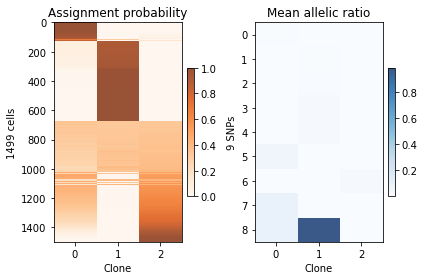

In [26]:
from vireoSNP.plot.base_plot import heat_matrix
plt.subplot(121)
im = heat_matrix(mquad_modelCA.ID_prob, cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True, interpolation = 'none')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Assignment probability")
plt.xlabel("Clone")
plt.ylabel("%d cells" %(mquad_modelCA.n_cell))
plt.xticks(range(mquad_modelCA.n_donor))

plt.subplot(122)
AF = mquad_modelCA.beta_mu
im = heat_matrix(AF, cmap='Blues', alpha=0.8, 
                display_value=False, row_sort=True, interpolation='none', aspect='auto')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Mean allelic ratio")
plt.xlabel("Clone")
plt.ylabel("%d SNPs" %(mquad_modelCA.n_var))
plt.xticks(range(mquad_modelCA.n_donor))
plt.tight_layout()

In [27]:
np.sum(np.max(mquad_modelCA.ID_prob, axis=1) > 0.8)/mquad_modelCA.n_cell

0.524349566377585